In [29]:
import torch
import torch_geometric
from utils import vis_grid, vis_from_pyg
from torch_geometric.datasets import MoleculeNet
from torch_geometric.loader import DataLoader
import random


dataset = MoleculeNet("datasets/", "BACE")
atom_dims = dataset.num_node_features
bond_dims = dataset.num_edge_features

# Convert dataset to a list of Data objects
data_list = list(dataset)
# Shuffle (these datasets have all the labels at one end)
random.shuffle(data_list)
dataset = data_list


First we need to make it a dataloader, instead of a dataset.

In [30]:
train_prop, val_prop, test_prop = 0.6, 0.2, 0.2
n_train, n_val, n_test = int(train_prop*len(dataset)), int(val_prop*len(dataset)), int(test_prop*len(dataset))
train, val, test = dataset[:n_train], dataset[n_train:-n_test], dataset[-n_test:]
train_loader = DataLoader(train, batch_size = 128, shuffle = True)
val_loader = DataLoader(val, batch_size = 128, shuffle = True)
test_loader = DataLoader(test, batch_size = 128, shuffle = True)

### Get the model

See `graph_tasks.ipynb` for more details + implementation stuff

In [31]:
from utils import GenericEncoder, GNNBlock, GraphModel

out_dim   = 1 # Binary classification

emb_dim = 128
n_layers = 5

atom_encoder = GenericEncoder(emb_dim, atom_dims)
bond_encoder = GenericEncoder(emb_dim, bond_dims)
out_layer    = GenericEncoder(emb_dim, emb_dim)
gnn_block = GNNBlock(emb_dim, n_layers, 0.1)

model = GraphModel(atom_encoder,
                   bond_encoder,
                   gnn_block,
                   out_layer)

print(model)

GraphModel(
  (node_encoder): GenericEncoder(
    (model): Sequential(
      (0): Linear(in_features=9, out_features=128, bias=True)
      (1): ReLU()
    )
  )
  (edge_encoder): GenericEncoder(
    (model): Sequential(
      (0): Linear(in_features=3, out_features=128, bias=True)
      (1): ReLU()
    )
  )
  (gnn_block): GNNBlock(
    (convs): ModuleList(
      (0-4): 5 x GINEConv(nn=Sequential(
        (0): Linear(in_features=128, out_features=256, bias=True)
        (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Linear(in_features=256, out_features=128, bias=True)
      ))
    )
    (bns): ModuleList(
      (0-4): 5 x BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (output_layer): GenericEncoder(
    (model): Sequential(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): ReLU()
    )
  )
)


## Contrastive learning

Contrastive learning is a semi-supervised representation learning technique.

In its simplest form (like here) it goes like this:

1. Take an input sample (graph)
2. Augment it in some way, two times (for example drop some edges)
3. Plug both into the encoder
4. Calculate loss based on how close together the two augmentations are

### Augmentation

We'll just be using random edge dropping

In [32]:
import random
from torch_geometric.utils import to_undirected

def drop_edges_randomly(data, drop_ratio):
    edge_index = data.edge_index  # [2, num_edges] tensor
    num_edges = edge_index.size(1)
    
    # Determine how many edges to drop
    num_edges_to_drop = int(drop_ratio * num_edges)
    drop_indices = edge_index[:num_edges_to_drop]  # Select the first 'num_edges_to_drop' indices

    # Mask the edges to keep
    mask = torch.ones(num_edges, dtype=torch.bool)
    mask[drop_indices] = False

    # Keep only the edges that were not dropped
    new_edge_index = edge_index[:, mask]

    if 'edge_attr' in data:
        edge_attr = data.edge_attr  # [num_edges, num_features]
        new_edge_attr = edge_attr[mask]  # Keep attributes of the remaining edges
    else:
        new_edge_attr = None

    # Create a new graph with the remaining edges and their attributes
    new_data = data.clone()
    new_data.edge_index = new_edge_index
    new_data.edge_attr = new_edge_attr

    return new_data

### What does this look like?

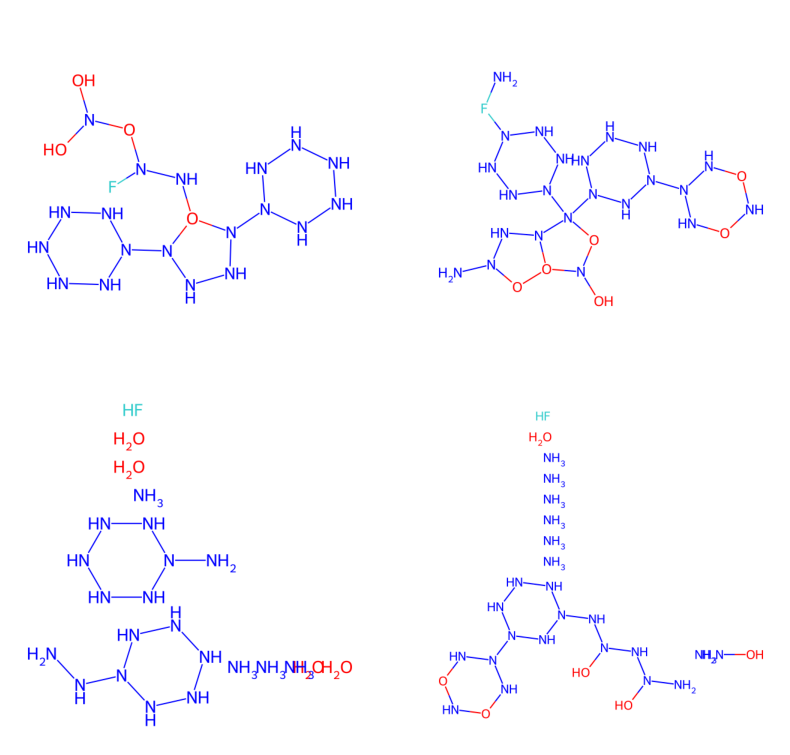

In [33]:
vis_grid(dataset[:2] + [drop_edges_randomly(d, 0.5) for d in dataset[:2]], filename="ogbg", save = False)

Now for the loss function

This is from [GraphCL](https://arxiv.org/abs/2010.13902) but you could also use `torch.functional.cosine_similarity`.

It computes the similarity between embeddings for all pairs of graphs, then promotes the pairs of augmentations of the same sample that should have similar embeddings.

In [34]:
def cl_loss(x1, x2):
    # CL loss from GraphCL

    T = 0.5
    batch_size, _ = x1.size()

    x1_abs = x1.norm(dim=1)
    x2_abs = x2.norm(dim=1)

    sim_matrix = torch.einsum('ik,jk->ij', x1, x2) / torch.einsum('i,j->ij', x1_abs, x2_abs)
    sim_matrix = torch.exp(sim_matrix / T)
    pos_sim = sim_matrix[range(batch_size), range(batch_size)]
    loss = pos_sim / (sim_matrix.sum(dim=1) - pos_sim)
    loss = - torch.log(loss).mean()
    return loss

## Training loop
This is a very minimal example, in reality training would be over a much larger dataset and for much more iterations.

In [35]:
from tqdm import tqdm

# This is from my own work
def train_epoch_random_edges(dataloader,
                      model, model_optimizer,
                      drop_proportion = 0.2):
    """
    single train epoch for encoder with random edge dropping as augmentation
    Args:
        dataloader: dataloader (see get_train_loader)
        model: encoder
        model_optimizer: optimizer for model
        model_loss_all: stores losses for each batch

    Returns:
        model_loss_all: loss for epoch
    """
    model_loss_all = 0.
    device = "cuda" if torch.cuda.is_available() else "cpu"
    for batch in tqdm(dataloader, leave = False):
        # set up
        batch = batch.to(device)
        # # train (model) to minimize contrastive loss
        model.train()
        # view_learner.eval()
        model.zero_grad()
        # Need to augment each sample twice
        aug1 = drop_edges_randomly(batch.clone(), drop_proportion)
        aug2 = drop_edges_randomly(batch.clone(), drop_proportion)

        x_aug_1 = model(aug1)
        x_aug_2 = model(aug2)

        model_loss = cl_loss(x_aug_1, x_aug_2) #
        # model_loss = model.calc_loss(x_aug_1, x_aug_2)
        model_loss_all += model_loss.item() * batch.num_graphs

        # standard gradient descent formulation
        model_loss.backward()
        model_optimizer.step()

    return model_loss_all



100%|██████████| 5/5 [00:06<00:00,  1.36s/it]


## Validation

At the moment this just calculates loss. What would be a better validation metric?

**Implement a better validation metric**

*(Hint: The dataset has its own classification task)*

In [ ]:

# This is from my own work
def val_epoch_random_edges(dataloader,
                      model, model_optimizer,
                      drop_proportion = 0.2):
    model_loss_all = 0.
    device = "cuda" if torch.cuda.is_available() else "cpu"
    with torch.no_grad():
        for batch in tqdm(dataloader, leave = False):
            # set up
            batch = batch.to(device)
            # # train (model) to minimize contrastive loss
            model.eval()

            aug1 = drop_edges_randomly(batch.clone(), drop_proportion)
            aug2 = drop_edges_randomly(batch.clone(), drop_proportion)

            x_aug_1 = model(aug1)
            x_aug_2 = model(aug2)
        

            model_loss = cl_loss(x_aug_1, x_aug_2) #
            # model_loss = model.calc_loss(x_aug_1, x_aug_2)
            model_loss_all += model_loss.item() * batch.num_graphs

    return model_loss_all


## Train

- Define parameters
- Track losses

In [ ]:

n_epochs = 5
drop_proportion = 0.1
model_optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model_train_losses = []
model_val_losses = []
pbar = tqdm(range(n_epochs))
for epoch_n in pbar:
    model_loss_all = train_epoch_random_edges(train_loader,
                                                model, model_optimizer,
                                                drop_proportion=drop_proportion)
    model_train_losses.append(model_loss_all)
    
    if epoch_n % 5 == 0:
        val_loss_all = train_epoch_random_edges(train_loader,
                                                    model, model_optimizer,
                                                    drop_proportion=drop_proportion)
        model_val_losses.append(val_loss_all)


## Testing

The point of representation learning is to learn good... representations. Incredible.

This, in practise, can mean two things:

- Predict properties + perform tasks without any more training (zero-shot)
- Train on supervised tasks faster (few-shot)
- Perform better on new data (transfer)

*These are not official definitions*

Here we load a different molecule dataset (BBBP) with a binary classification task:

In [42]:
dataset = MoleculeNet("datasets/", "BBBP")
atom_dims = dataset.num_node_features
bond_dims = dataset.num_edge_features

# Convert dataset to a list of Data objects
data_list = list(dataset)
# Shuffle (these datasets have all the labels at one end)
random.shuffle(data_list)
dataset = data_list

train_prop, val_prop, test_prop = 0.6, 0.2, 0.2
n_train, n_val, n_test = int(train_prop*len(dataset)), int(val_prop*len(dataset)), int(test_prop*len(dataset))
train, val, test = dataset[:n_train], dataset[n_train:-n_test], dataset[-n_test:]
train_loader = DataLoader(train, batch_size = 64, shuffle = True)
val_loader = DataLoader(val, batch_size = 64, shuffle = True)
test_loader = DataLoader(test, batch_size = 64, shuffle = True)

Processing...
/opt/anaconda3/envs/intro_pyg/lib/python3.11/site-packages/torch_geometric/datasets/molecule_net.py:213: UserWarning: Skipping molecule 'O=N([O-])C1=C(CN=C1NCCSCc2ncccc2)Cc3ccccc3' since it resulted in zero atoms
  warnings.warn(f"Skipping molecule '{smiles}' since it "
/opt/anaconda3/envs/intro_pyg/lib/python3.11/site-packages/torch_geometric/datasets/molecule_net.py:213: UserWarning: Skipping molecule 'c1(nc(NC(N)=[NH2])sc1)CSCCNC(=[NH]C#N)NC' since it resulted in zero atoms
  warnings.warn(f"Skipping molecule '{smiles}' since it "
/opt/anaconda3/envs/intro_pyg/lib/python3.11/site-packages/torch_geometric/datasets/molecule_net.py:213: UserWarning: Skipping molecule 'Cc1nc(sc1)\[NH]=C(\N)N' since it resulted in zero atoms
  warnings.warn(f"Skipping molecule '{smiles}' since it "
/opt/anaconda3/envs/intro_pyg/lib/python3.11/site-packages/torch_geometric/datasets/molecule_net.py:213: UserWarning: Skipping molecule 's1cc(CSCCN\C(NC)=[NH]\C#N)nc1\[NH]=C(\N)N' since it result

For one-shot learning, we need embeddings. These are the representations the model has learnt to produce.

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.svm import SVC

def get_embeddings(encoder, loader):
    embeddings = []
    labels = []
    with torch.no_grad():
        # Your code here!
        # Except my code is already here
        # If you're a very keen kid you could improve this with concatenation and other optimisations
        for batch in tqdm(loader):
            embedding = encoder.forward(batch)
            embeddings.append(embedding)
            labels.append(batch.y)

    # Produce one big tensor of embeddings and labels
    embeddings = torch.concatenate(embeddings, 0)
    labels = torch.concatenate(labels)
    # Move to numpy arrays for the later stuff
    return embeddings.cpu().numpy(), labels.cpu().numpy()

train_emb, train_y = get_embeddings(model, train_loader)
val_emb, val_y = get_embeddings(model, val_loader)
test_emb, test_y = get_embeddings(model, test_loader)



100%|██████████| 7/7 [00:00<00:00, 66.83it/s]


### Visualisation

We now have embeddings and labels for these molecules - but they're very high dimensional `emb_dim`D.
We can only really visualise 2D, so use [dimensionality reduction](https://medium.com/@alexowendavies/understanding-dimensionality-reduction-b319a6e60c80) to drop that down to 2D.

We can colour according to the molecule's label (what we want to predict).

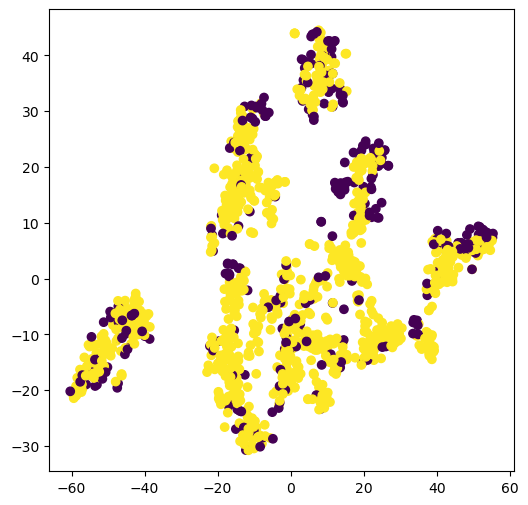

In [44]:
fig, ax = plt.subplots(figsize = (6,6))

# This is lazy. Fiddle with the parameters - what changes? What does that mean? What?
tsne = TSNE().fit_transform(train_emb)

ax.scatter(tsne[:,0], tsne[:,1], c = train_y[:,0])
plt.show()

### Linear models

How well does a support vector classifier *(a kind of linear model)* predict this task?

In [39]:
from sklearn.metrics import roc_auc_score
lin_classifier = SVC()
lin_classifier.fit(train_emb, train_y[:,0])

pred_test = lin_classifier.predict(test_emb).flatten()
test_y = test_y[:,0].flatten()

correct = np.sum(pred_test == test_y)
print(f"Accuracy: {100 * correct / pred_test.shape[0]}")
print(f"Class weighting: {np.sum(test_y) / test_y.shape[0]}")
print(f"ROC: {roc_auc_score(test_y, pred_test)}")

Accuracy: 92.9054054054054
Class weighting: 0.9290540540540541
ROC: 0.5
